In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['savefig.dpi'] = 600
%matplotlib inline

import matplotlib.pyplot as plt

import re
import sys
import os
import os.path
sys.path.append('../python')

import plot_info
from plot_info import showAndSave
import netCDF4
from IPython.core.display import display, HTML
import matplotlib2tikz
import copy
import json
import traceback
with open('structure_functions_functionals_configs.json') as f:
    configurations = json.load(f)

def for_each_config(f):
    oldPrefix = copy.deepcopy(showAndSave.prefix)
    for conf in configurations.keys():
        
        plot_info.console_log(conf)
        headline(configurations[conf]['name'])
        showAndSave.prefix = oldPrefix + conf
        try:
            f(configurations[conf])
        except Exception as e:
            message = "Skipping {fname} on {conf} ({confname})\n\tReason: {reason}\nTraceback: {traceback}".format(fname=str(f),
                                                                                                       conf=conf, 
                                                                                                       confname=configurations[conf]['name'],
                                                                                                       reason=str(e),
                                                                                                     traceback=traceback.format_exc())
            plot_info.console_log(message)
            print(message)
    showAndSave.prefix=oldPrefix

plot_info.set_notebook_name("structure_variance.ipynb")

C:\Users\kjeti\Anaconda3\lib\site-packages\matplotlib2tikz\__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


In [2]:
def headline(text):
    display(HTML("<h1>%s</h1>"%text))
def h2(text):
    display(HTML("<h2>%s</h2>"%text))
def h3(text):
    display(HTML("<h3>%s</h3>"%text))
def h4(text):
    display(HTML("<h4>%s</h4>"%text))
def h5(text):
    display(HTML("<h4>%s</h4>"%text))

In [3]:
def readnetcdf4(filename, variable,sample):
    
    with netCDF4.Dataset(filename) as f:
        return f.variables[f'sample_{sample}_{variable}'][:,0,0]
    
def get_number_of_samples(filename):
    max_sample = 0
    with netCDF4.Dataset(filename) as f:
        for v in f.variables.keys():
            match = re.search(r'sample_(\d+)_', v)
            if match:
                sample = int(match.group(1))
                max_sample = max(sample, max_sample)
    return max_sample+1

def upscale(d, r):

    while d.shape[0] < r:
       
        d = np.repeat(d,2,0)
    return d


def plotscalings(d,d_var, r,title, exponent_mean, exponent_var):
    N = len(d)
    H = np.linspace(0, 64./2048,N)
   
    poly = np.polyfit(np.log(H[1:]), np.log(d[1:]),1)
    
        
    fig = plt.figure(0)
    plt.title(title)
    ax = plt.gca()
    
    p = ax.errorbar(H[1:] ,d[1:], yerr=np.sqrt(d_var[1:]), label='$N=%d$'%r)
    ax.set_xscale("log", basex=2)
    ax.set_yscale("log", basey=2)
    ax.loglog(H[1:], np.exp(poly[1])*H[1:]**(poly[0]), '--',
              label=f'$\\mathcal{{O}}(h^{{{poly[0]:.2f}}})$'
              f'($\\mathrm{{exponent}}={exponent_mean:.2f}\\pm{np.sqrt(exponent_var):.3f}$)',
              color=p[0].get_color(), basex=2, basey=2)
    box = ax.get_position()
    
    plot_info.legendLeft()
    ax.grid(True)

def estimate_exponents(samples, resolution):
    exponent = []
    H = np.linspace(0, 32.0/1024., int(32*resolution/1024))
    for sample in samples:
        poly = np.polyfit(np.log(H[1:]), np.log(sample[1:]), 1)
        
        exponent.append(poly[0])
    return exponent


def getlineintegral(filename, variables, resolution, p):
    all_samples = []
    for sample in range(get_number_of_samples(filename)):
        structure = np.zeros(int(32*resolution/1024))
        for variable in variables:
            d = readnetcdf4(filename, variable, sample)
            dx = 1.0/resolution
            
            for h in range(1,len(d)):
                d[h] += d[h-1]
            for h in range(1,len(d)):
                d[h] /=(2*h+1)**2
                
            structure += d
        all_samples.append(structure**(1.0/p))
    exponents = estimate_exponents(all_samples, resolution)
            
    return np.mean(all_samples, 0), np.var(all_samples, 0), np.mean(exponents), np.var(exponents)
    

kh


C:\Users\kjeti\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


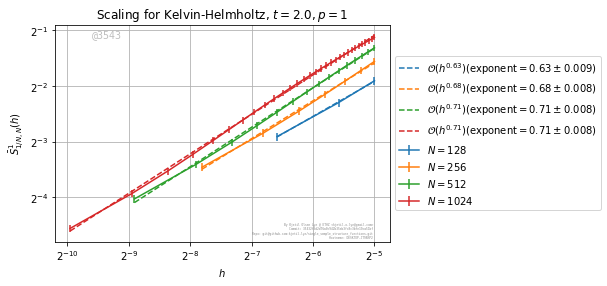

Skipping <function convergence_structure_functions at 0x0000020A8D59E048> on kh (Kelvin-Helmholtz)
	Reason: name 'variable' is not defined
Traceback: Traceback (most recent call last):
  File "<ipython-input-1-db8ea7cb3765>", line 33, in for_each_config
    f(configurations[conf])
  File "<ipython-input-4-5f2352fc1877>", line 54, in convergence_structure_functions
    plt.loglog(resolutions[1:],errors,'-o',label='%s' % variable, basex=2, basey=2)
NameError: name 'variable' is not defined

Skipping <function convergence_structure_functions at 0x0000020A8D59E048> on kh (Kelvin-Helmholtz)
	Reason: name 'variable' is not defined
Traceback: Traceback (most recent call last):
  File "<ipython-input-1-db8ea7cb3765>", line 33, in for_each_config
    f(configurations[conf])
  File "<ipython-input-4-5f2352fc1877>", line 54, in convergence_structure_functions
    plt.loglog(resolutions[1:],errors,'-o',label='%s' % variable, basex=2, basey=2)
NameError: name 'variable' is not defined

fbb_0_5


In [ ]:
def convergence_structure_functions(config):
    headline("Component convergence Box averaged structure functions")
    variables = ['rho', 'mx','my', 'E']
    perturbations = config['perturbations']
    Tarray = config['Tarray']
    resolutions = config['resolutions']
    cube_filename = config['cube_filename']
    name = config['name']
    maxT = config['maxT']
    for perturbation in perturbations:
        h2("perturbation = %.2f" % perturbation)
        for p in [1,2,3]:
            h3("p = %d" % p)
            timeArray = Tarray
                
            for t in timeArray:
                h4("t = %f" % (0.2*t))

                errors = np.zeros(len(resolutions)-1)


                for (nr, resolution) in enumerate(resolutions):        
                    filename = cube_filename.format(perturbation = perturbation, p=p,t=t,resolution=resolution)

                    structure_mean, structure_variance, exponent_mean, exponent_var = getlineintegral(filename, variables, resolution, p)
                    

                    if resolution > resolutions[0]:
                        errors[nr-1] = abs(structure_mean[-1]-structure_mean_prev[-1])
                    structure_mean_prev = np.repeat(structure_mean,2,0)
                    
                    t_start = config.get("t_start", 0.0)
                    time = t_start
                    if max(timeArray) > 0:
                        time += t * maxT / max(timeArray)
                    if len(perturbations) > 1:
                        title = f'Scaling for {name}, $t={time},p={p},\\varepsilon={perturbation}$'
                    else:
                        title = f'Scaling for {name}, $t={time},p={p}$'

                    plotscalings(structure_mean, structure_variance, resolution, title, 
                                 exponent_mean, exponent_var)
                    
                    plt.xlabel('$h$')
                    if p != 1:
                        plt.ylabel('$\\left(\\bar{S}^{%d}_{1/N,N}(h)\\right)^{\\frac{1}{%d}}$' % (p,p))
                    else:
                        
                        plt.ylabel('$\\bar{S}^{%d}_{1/N,N}(h)$' % (p))
                for nr in range(len(resolutions)-1):
                    errors[nr] = abs(errors[nr])

                showAndSave('scaling_mean_var_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                plt.loglog(resolutions[1:],errors, '-o', basex=2, basey=2)
                
                plt.ylim([2.0**(np.floor(np.log2(min(errors))))/1.1, 1.1*2.0**(np.ceil(np.log2(max(errors))))])
                if len(perturbations)>1:
                    title = f'{name}, $p={p}, t={time}, \\varepsilon={perturbation}$'
                else:
                    title = f'{name}, $p={p}, t={time}$'

                plt.title(title)
                plt.xlabel('Resolution')
                plt.ylabel('$|S^{%d}_{\Delta x,M}(h_{\\max})-S^{%d}_{2\Delta x,M}(h_{\\max})|$' % (p,p) )
                plt.grid(True)
                plt.xticks(resolutions[1:], ['${r}^3$'.format(r=r) for r in resolutions[1:]])
                showAndSave('convergence_mean_{name}_{p}_{perturbation}_{time}'.format(name=name.replace('$','').replace(' ',"_").replace('=',''), p=p, perturbation=perturbation, time=t))
                
for_each_config(convergence_structure_functions)

In [ ]:
x=linspace(0,1,20)
plt.errorbar(x, x**2, yerr=np.sqrt(x))